## Импорт библиотек

In [ ]:
%pip install -q --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.5.2.


In [ ]:
from IPython.display import Markdown, display, clear_output
from joblib import load

import os
import json
import joblib
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [ ]:
from sklearn.experimental import enable_halving_search_cv # noqa

from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, matthews_corrcoef, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from imblearn.over_sampling import SMOTE

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import torch.nn.functional as F
from torch import nn, optim

import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    os.chdir('/content/drive/MyDrive/Colab_Notebooks/ml_projects')
except FileNotFoundError:
    os.chdir('/content/drive/MyDrive/4 курс/Прикладные задачи машинного обучения/Проект "Астероиды"')

os.getcwd()

'/content/drive/MyDrive/4 курс/Прикладные задачи машинного обучения/Проект "Астероиды"'

## Вспомогательные функции

In [ ]:
# Чтение данных их zip архива
zipDataPath = "data/nasa_archive.zip"

with zipfile.ZipFile(file=zipDataPath, mode='r') as f:
    print(f.namelist())
    f.extractall('data')

['nearest-earth-objects(1910-2024).csv']


In [ ]:
# Фукнция для построения "ящиков с усами"
def box_plotter(X, y):
    fig, axes = plt.subplots(2, 3)
    axes = axes.flatten()

    for i, column in enumerate(X.columns):
        sns.boxplot(data=X, x=column, hue=y, ax=axes[i])
        axes[i].set_title(column)
        axes[i].legend([],[], frameon=False)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
# Функия для построения распределений разных признаков
def plotter(X, y):
    plt.figure(figsize=(10, 4))
    sns.histplot(data=X, x='absolute_magnitude', hue=y)
    plt.show()

    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    sns.histplot(data=X, x='estimated_diameter_min', hue=y, ax=axes[0, 0])
    sns.histplot(data=X, x='estimated_diameter_min', hue=y, ax=axes[0, 1])
    axes[0, 1].set_xscale('log')

    sns.histplot(data=X, x='estimated_diameter_max', hue=y, ax=axes[1, 0])
    sns.histplot(data=X, x='estimated_diameter_max', hue=y, ax=axes[1, 1])
    axes[1, 1].set_xscale('log')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.histplot(data=X, x='relative_velocity', hue=y)
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.histplot(data=X, x='miss_distance', hue=y)
    plt.show()

## Анализ и предобработка данных

In [ ]:
dataset = pd.read_csv('data/nearest-earth-objects(1910-2024).csv')

In [ ]:
print(f"Датасет включает в себя {len(dataset)} записей о {len(dataset['neo_id'].unique())} ближайших к Земле астероидах и их параметрах.")

Датасет включает в себя 338199 записей о 33514 ближайших к Земле астероидах и их параметрах.


Датасет нацелен на классификацию объектов на опасные и неопасные для Земли. <br><br>
Состав датасета:


*   **neo_id** — уникальный идентификатор объекта
*   **name** — наименование объекта в системе NASA
*   **absolute_magnitude** — абсолютная звездная величина, безразмерная числовая характеристика яркости объекта; чем меньше значение звёздной величины, тем ярче данный объект; для астероидов абсолютная величина принимается равной видимой величине, которую они имели бы на расстоянии 1 а.е. от Солнца и от наблюдателя
*   **estimated_diameter_min** — минимальный предположительный диаметр в километрах
*   **estimated_diameter_max** — максимальный предположительный диаметр в километрах
*   **orbiting_body** — объект, вокруг которого  вращается астероид
*   **relative_velocity** — скорость относительно Земли
*   **miss_distance** — пропущенное расстояние в километрах
*   **is_hazardous** — бинарная метка опасности астероида для Земли



In [ ]:
dataset.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [ ]:
dataset.describe()

,neo_id,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,3.381990e+05,338171.000000,338171.000000,338171.000000,338199.000000,3.381990e+05
mean,1.759939e+07,22.932525,0.157812,0.352878,51060.662908,4.153535e+07
std,2.287225e+07,2.911216,0.313885,0.701869,26399.238435,2.077399e+07
min,2.000433e+06,9.250000,0.000511,0.001143,203.346433,6.745533e+03
25%,3.373980e+06,20.740000,0.025384,0.056760,30712.031471,2.494540e+07
50%,3.742127e+06,22.800000,0.073207,0.163697,47560.465474,4.332674e+07
75%,5.405374e+07,25.100000,0.189041,0.422708,66673.820614,5.933961e+07
max,5.446281e+07,33.580000,37.545248,83.953727,291781.106613,7.479865e+07


In [ ]:
n = dataset[dataset.isnull().any(axis=1)]
print(f'Датасет длиной {len(dataset)} содержит в себе {len(n)} записей с пустыми значениями')

Датасет длиной 338199 содержит в себе 28 записей с пустыми значениями


In [ ]:
# В связи с отсутствием данных об астероидах в других записях заполнение пустых значений не является возможным.
for i in list(n['name'].unique()):
    print(f"Астероид {i} фигурирует в {len(dataset[dataset['name'] == i])} записях, из которых {len(n[n['name'] == i])} содержат пустые значения")

Астероид (2010 DJ77) фигурирует в 26 записях, из которых 26 содержат пустые значения
Астероид (2010 AW108) фигурирует в 1 записях, из которых 1 содержат пустые значения
Астероид (2010 CJ188) фигурирует в 1 записях, из которых 1 содержат пустые значения


In [ ]:
# Признак orbiting_body имеет всего одно значение - Earth (Земля)
dataset.nunique()

neo_id                     33514
name                       33514
absolute_magnitude          1778
estimated_diameter_min      1778
estimated_diameter_max      1778
orbiting_body                  1
relative_velocity         338189
miss_distance             337826
is_hazardous                   2
dtype: int64

In [ ]:
# Удалим следующие признаки: neo_id, name, orbiting_body
# Преобразуем целевую переменную из булевой в целочисленную
# Удалим пустые значения

dataset = dataset.drop(['neo_id', 'name', 'orbiting_body'], axis=1).dropna()
dataset['is_hazardous'] = dataset['is_hazardous'].astype(int)

In [ ]:
dataset.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,19.14,0.394962,0.883161,71745.401048,5.814362e+07,0
1,18.50,0.530341,1.185878,109949.757148,5.580105e+07,1
2,21.45,0.136319,0.304818,24865.506798,6.720689e+07,0
3,20.63,0.198863,0.444672,78890.076805,3.039644e+07,0
4,22.70,0.076658,0.171412,56036.519484,6.311863e+07,0


In [ ]:
d = dataset[dataset['estimated_diameter_max'] < 3]

In [ ]:
# Из-за незначительности данного показателя в общем объеме данных дубликаты можно просто удалить
print(f"В датасете присутствует {dataset.duplicated().sum()} строк дубликатов.\n")

dataset.drop_duplicates(inplace=True)

В датасете присутствует 5 строк дубликатов.



In [ ]:
dataset['is_hazardous'].value_counts()

is_hazardous
0    295004
1     43162
Name: count, dtype: int64

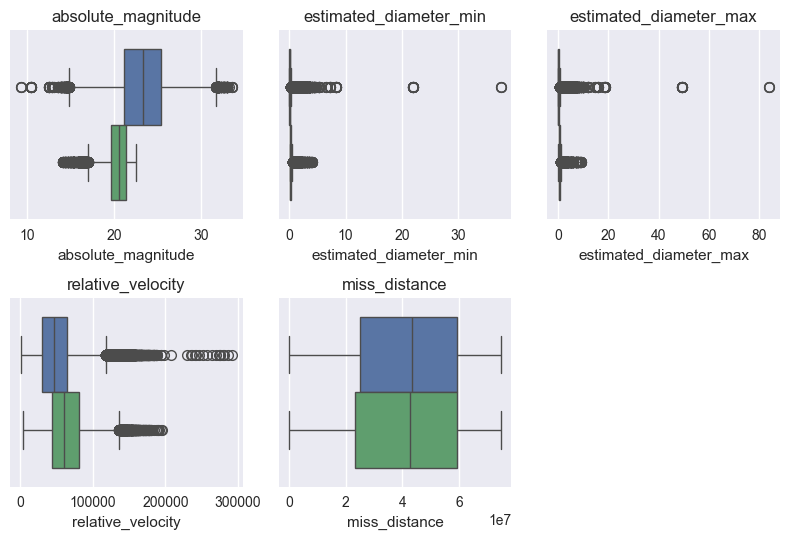

In [ ]:
box_plotter(dataset.drop(columns=['is_hazardous'], inplace=False), dataset['is_hazardous'])

In [ ]:
# Для борьбы с выбросами используем межквартильное расстояние
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = dataset.apply(stats.iqr)

dataset_clean = dataset[~((dataset < (Q1 - 30*IQR)) | (dataset > (Q3 + 30*IQR))).any(axis=1)]
dataset_clean.shape

(294954, 6)

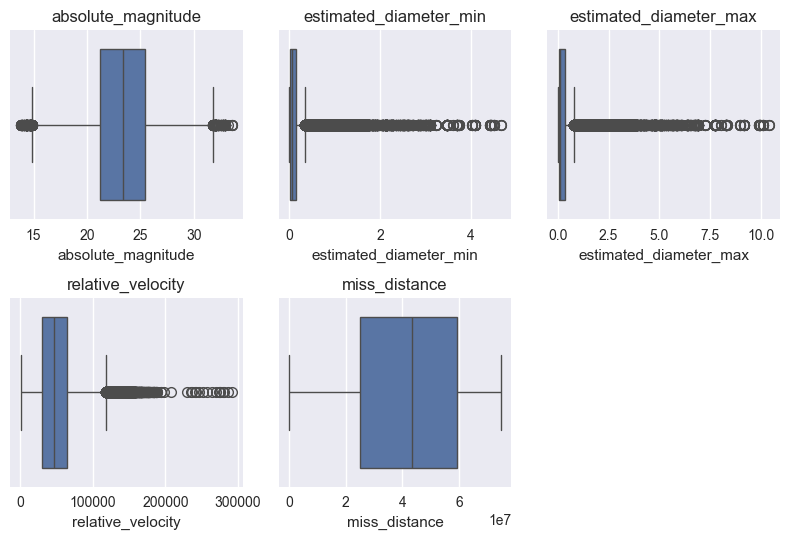

In [ ]:
box_plotter(dataset_clean.drop(columns=['is_hazardous'], inplace=False), dataset_clean['is_hazardous'])

In [ ]:
# Межквартильное расстояние показало себя плохим методом борьбы с выбросами
# т.к. при удалении "выбросов" в датасете остаются только неопасные астероиды
dataset_clean['is_hazardous'].value_counts()

is_hazardous
0    294954
Name: count, dtype: int64

In [ ]:
# В связи с этим было принято решение удалить лишь явно выделяющиеся на графике значения
to_drop = dataset[dataset['estimated_diameter_max'] > 10]
dataset_clean = dataset.drop(to_drop.index, axis=0)
print(to_drop.shape)
to_drop

(60, 6)


,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
4101,13.51,5.279040,11.804293,152450.609939,6.870373e+07,0
4206,9.25,37.545248,83.953727,61537.325800,5.705108e+07,0
6907,12.52,8.328273,18.622586,121732.543257,6.748902e+07,0
8600,13.05,6.524616,14.589486,63220.596112,4.758813e+07,0
17044,10.41,22.006703,49.208483,17340.422466,7.468781e+07,0
24486,12.52,8.328273,18.622586,88785.544625,6.655398e+07,0
26235,13.51,5.279040,11.804293,72358.706388,5.573596e+07,0
27079,13.85,4.513932,10.093458,46442.173812,7.165870e+07,0
28137,13.85,4.513932,10.093458,60310.552500,4.041616e+07,0
29953,13.05,6.524616,14.589486,66387.187727,4.488251e+07,0


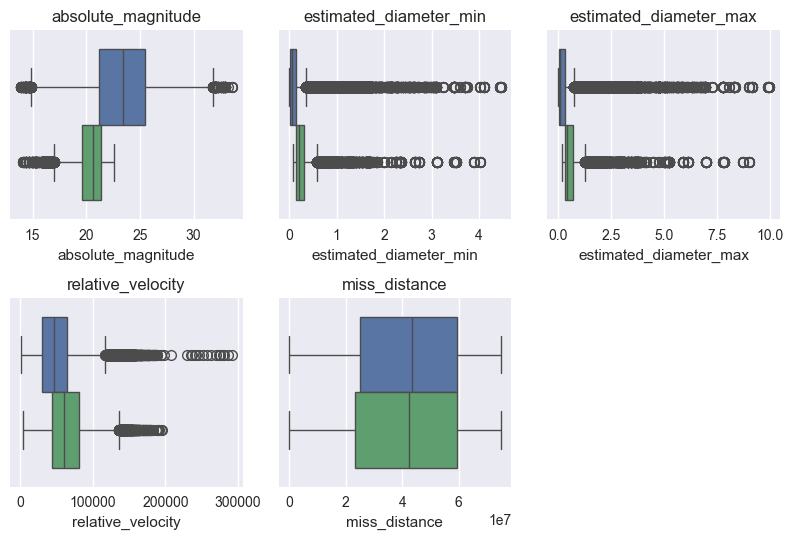

In [ ]:
box_plotter(dataset_clean.drop(columns=['is_hazardous'], inplace=False), dataset_clean['is_hazardous'])

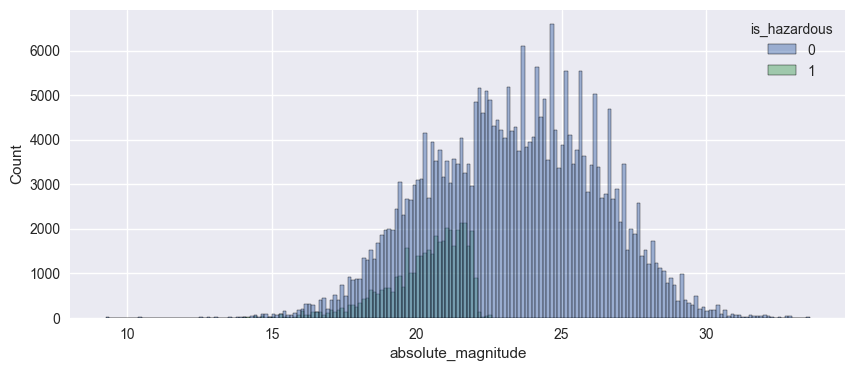

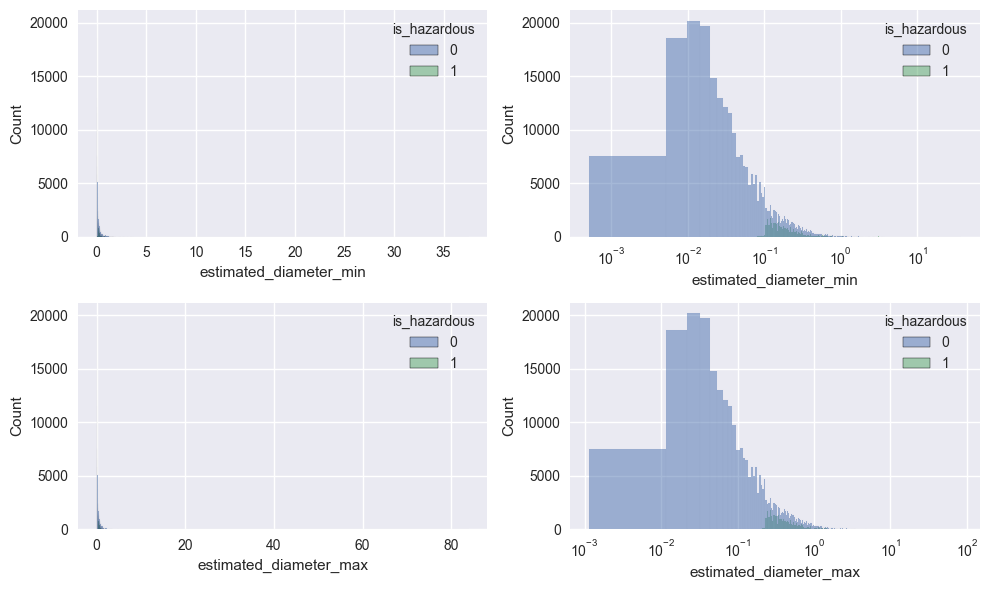

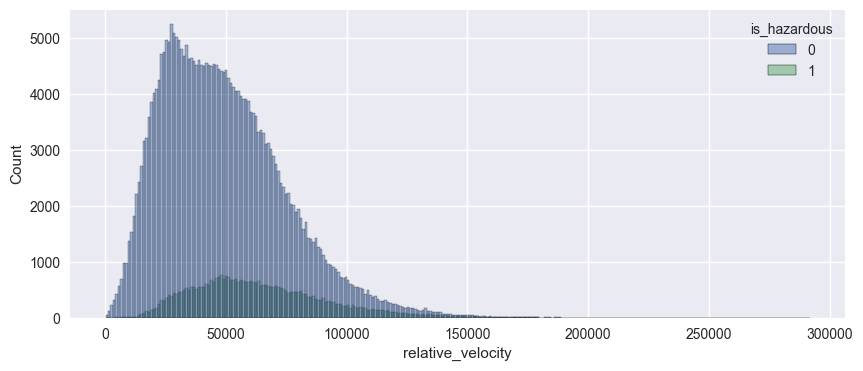

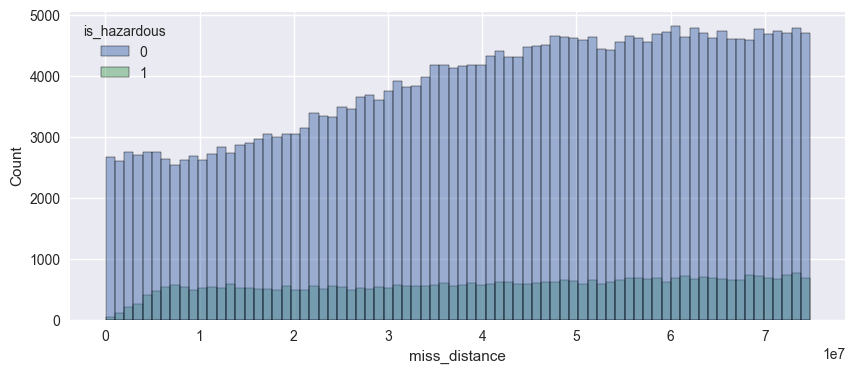

In [ ]:
plotter(dataset.drop(columns=['is_hazardous'], inplace=False), dataset['is_hazardous'])

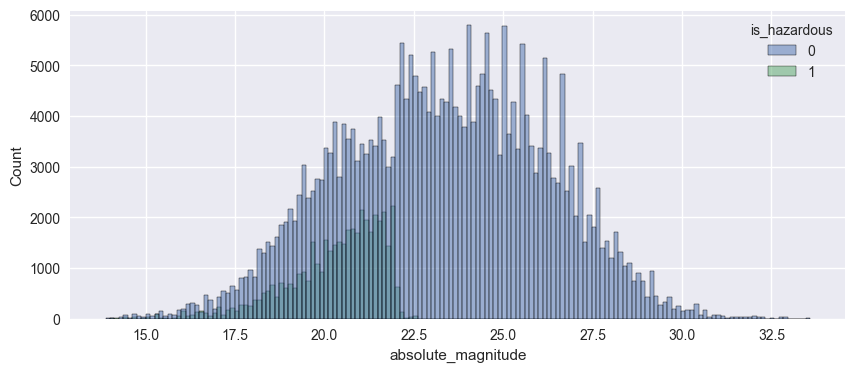

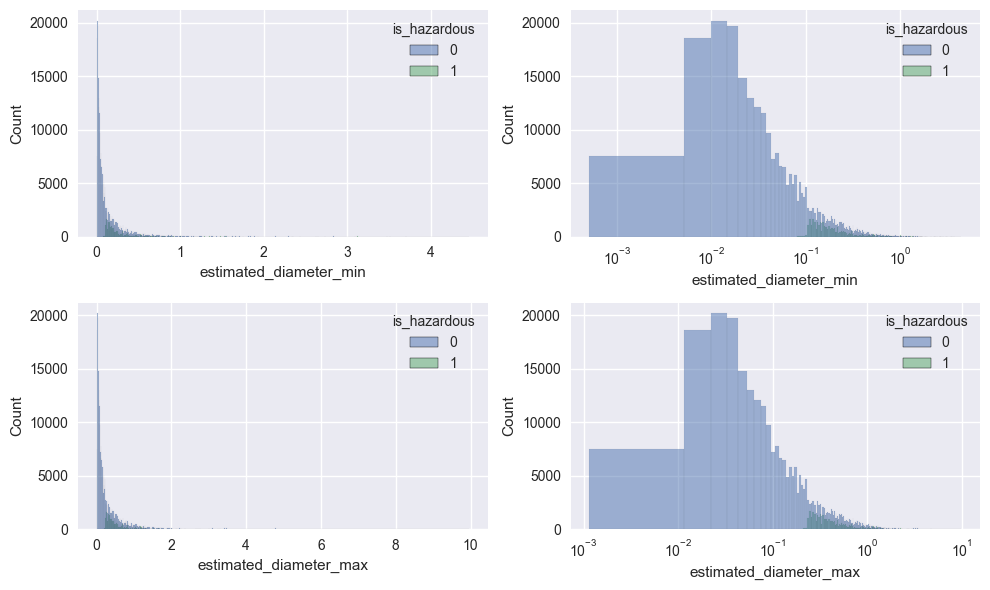

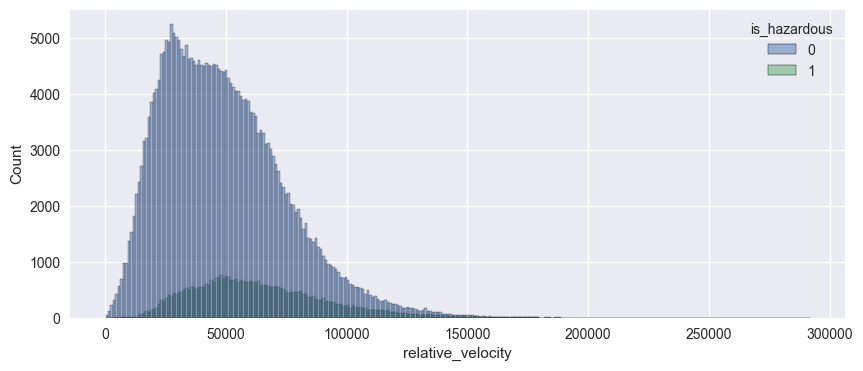

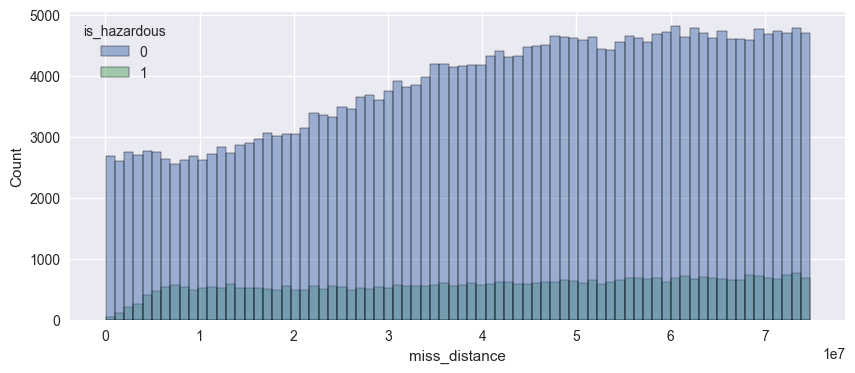

In [ ]:
plotter(dataset_clean.drop(columns=['is_hazardous'], inplace=False), dataset_clean['is_hazardous'])

<Axes: >

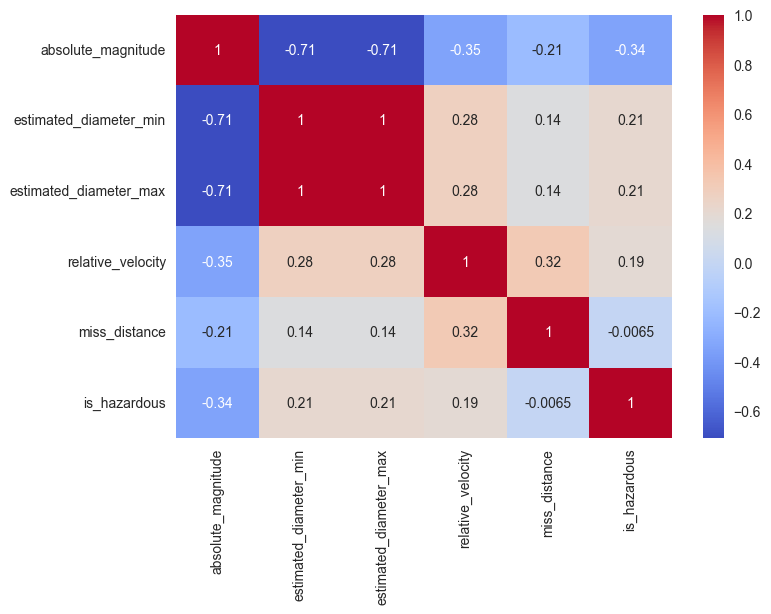

In [ ]:
corr_matrix = dataset_clean.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [ ]:
# Разделяем данные на обучающий и тестовый наборы (применяем SMOTE)
y = dataset_clean['is_hazardous']
X = dataset_clean.drop('is_hazardous', axis=1)

smote = SMOTE(random_state=37)
X_smote, y_smote = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=37, stratify=y_smote, shuffle=True)

In [ ]:
# благодаря параметру stratify = y приразделении данных было сохранено процентное соотношение значений целевой переменной
print(f"Соотношение опасных и безопасных астероидов в тренировочном наборе равно {round(y_train.value_counts()[1] / y_train.value_counts()[0] * 100, 3)}%")
print(f"Соотношение опасных и безопасных астероидов в тестовом наборе равно {round(y_test.value_counts()[1] / y_test.value_counts()[0] * 100, 3)}%")

Соотношение опасных и безопасных астероидов в тренировочном наборе равно 100.0%
Соотношение опасных и безопасных астероидов в тестовом наборе равно 100.0%


In [ ]:
dataset_smote = pd.DataFrame(X_smote, columns=dataset.columns[:-1])
dataset_smote['is_hazardous'] = y_smote

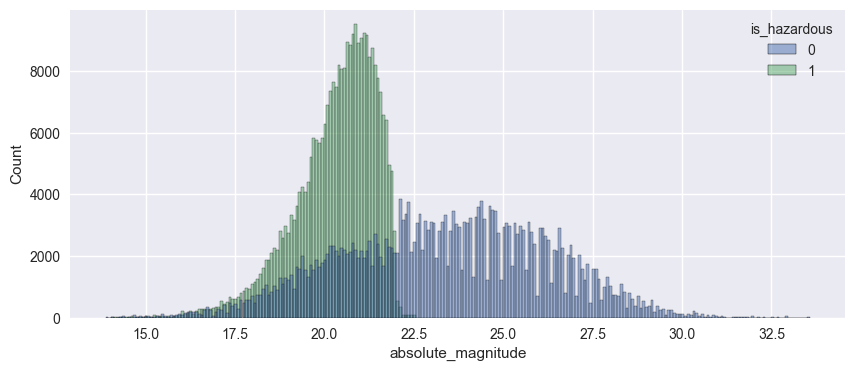

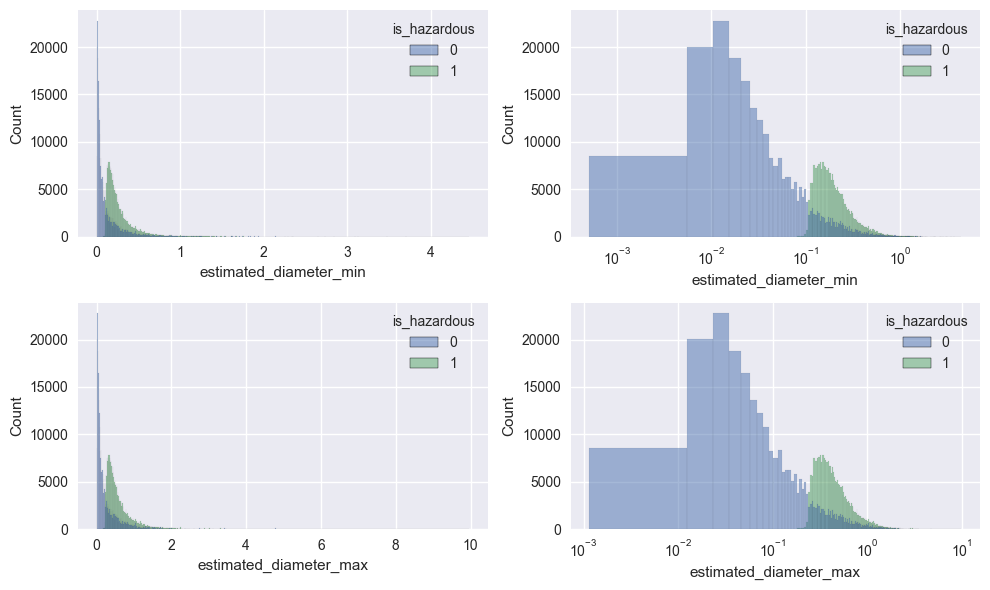

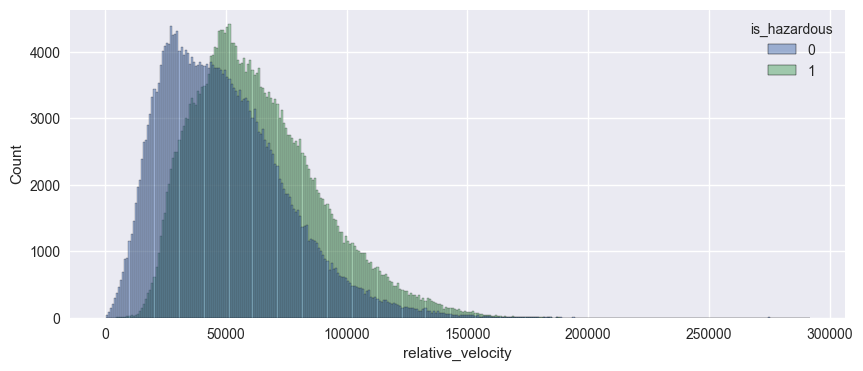

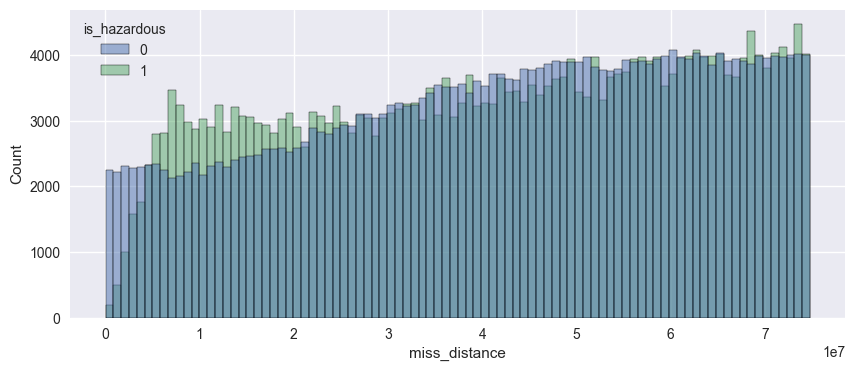

In [ ]:
plotter(dataset_smote.drop(columns=['is_hazardous'], inplace=False), dataset_smote['is_hazardous'])

In [ ]:
# Стандартизация данных
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
pd_x = pd.DataFrame(X_train, columns=['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance'])

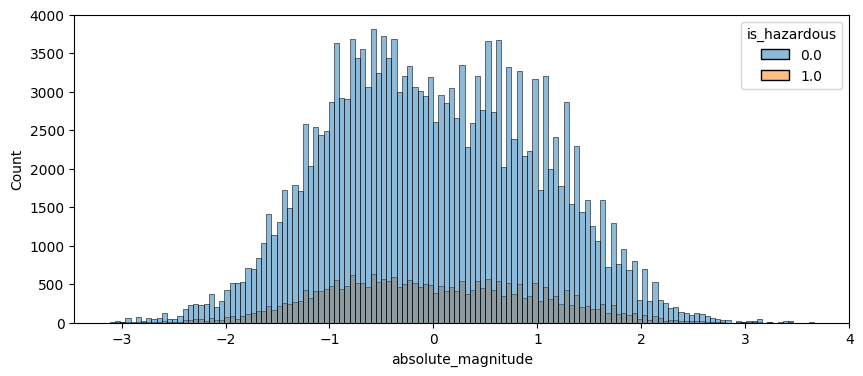

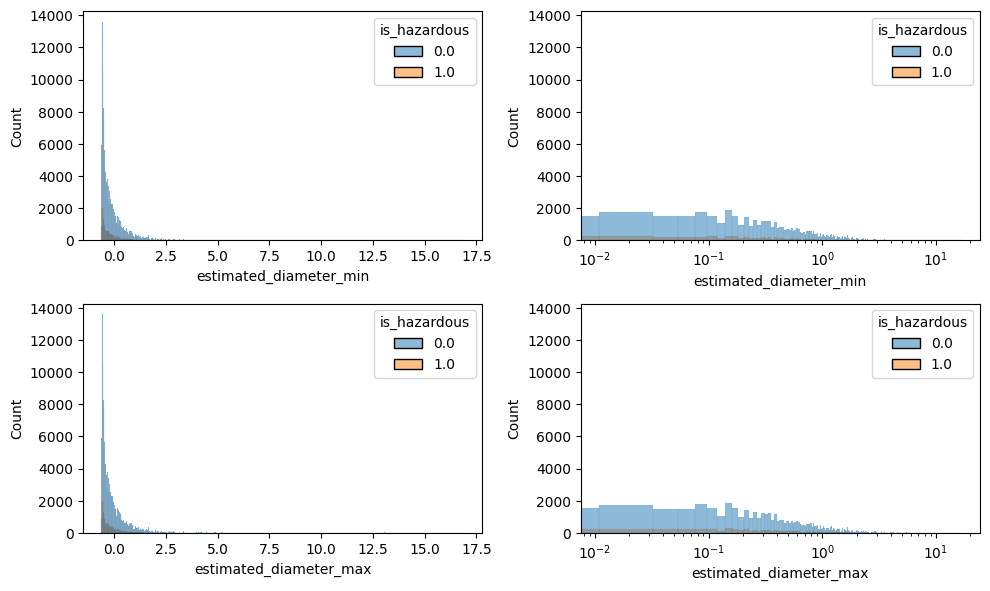

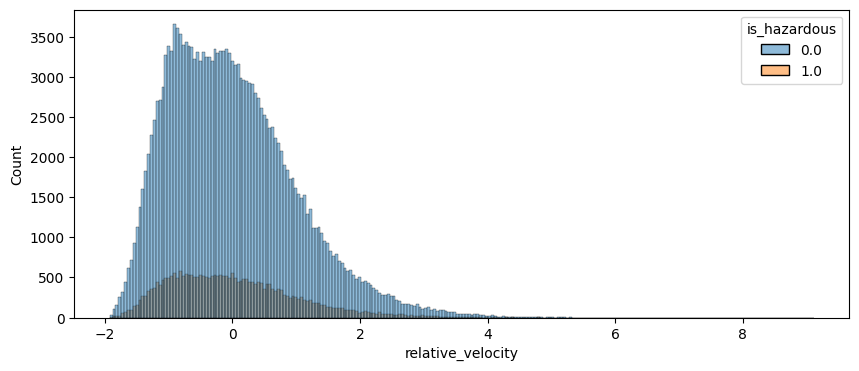

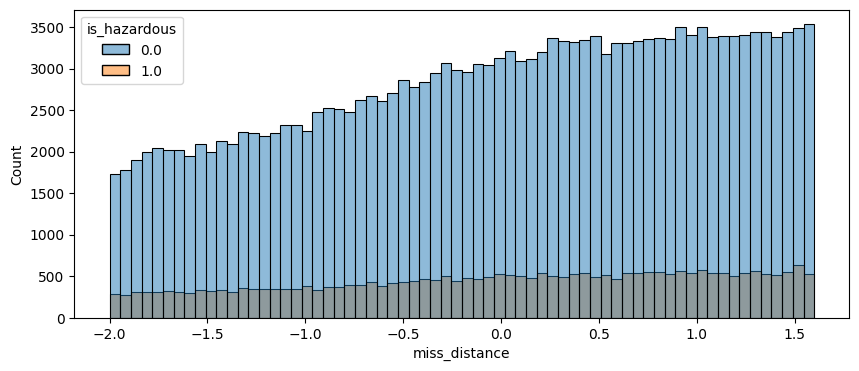

In [ ]:
plotter(pd_x, y_train)

In [ ]:
# Группируем данные (удобно для конвейера)
data = [X_train, X_test, y_train, y_test]

## Выбор модели

Каждая модель проходит несколько этапов обучения и тестирования:
* Подбор гиперпараметров (для экономии ресурсов использовался "халвинг" вместо поиска по сетке)
* Кросс-валидация
* Получение метрик (целевыми были выбраны ROC AUC и Recall, так-как первая показывает способность модели отличать классы друг от друга, а вторая показывате способность модели качественно работать с положительным классом, который более важен для нас)
* Построение матрицы путаницы (наглядно показывает, как модель справляется с классификацией в общем)

In [ ]:
# Подгружаем словарь для сохранения результатов работы каждой из моделей (или создаем новый)

if 'models_roc_auc_results.json' in os.listdir():
    with open('models_roc_auc_results.json', 'r') as f:
        results = json.load(f)

else:
    results = {}

### Классические модели машинного обучения

In [ ]:
# Создаем конвейер обучения и валидации модели
def pipeline(model, params, data):
    X_train, X_test, y_train, y_test = data

    halving_grid_search = HalvingGridSearchCV(model, params, cv=5)
    halving_grid_search.fit(X_train, y_train)

    clear_output()
    display(Markdown(f'### Best parameters: {halving_grid_search.best_params_}'))

    best_model = halving_grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, scoring='accuracy', cv=5)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    display(Markdown(f'### Learning curve:'))
    plt.figure(figsize=(6, 4))
    plt.style.use('seaborn-v0_8')
    sns.lineplot(x=[round(i / max(train_sizes), 2) for i in train_sizes], y=train_scores_mean, label='Training accuracy')
    sns.lineplot(x=[round(i / max(train_sizes), 2) for i in train_sizes], y=test_scores_mean, label='Validation accuracy')
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.title('Learning curve')
    plt.legend()
    plt.show()

    scores = cross_val_score(best_model, X_train, y_train, cv=5)
    display(Markdown(f'### Cross-validation score: {round(scores.mean(), 3)}\n'))

    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)

    report_df = pd.DataFrame(report).transpose().round(3)

    display(Markdown(f'### Classification report:'))
    display(report_df)

    y_pred_proba = best_model.predict_proba(X_test)[:,1]
    display(Markdown(f'### ROC AUC score = {round(roc_auc_score(y_test, y_pred_proba), 3)}'))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    display(Markdown(f'### ROC AUC curve:'))
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    display(Markdown(f'### Confusion matrix:'))
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    labels = ['not_hazardous', 'hazardous']
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='RdBu', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

    model_filename = os.path.join('models', f'{type(model).__name__}.joblib')
    joblib.dump(best_model, model_filename)

    return list(fpr), list(tpr), roc_auc

Логистическая регрессия --- подходит для задач бинарной классификации, где отношения между признаками и целевой переменной можно аппроксимировать линейной функцией.

Хоть на наших данных не проявляется четкая линейная зависимость между признаками и целевой переменной, использовать логистическую регрессию удобно в качестве отправной точки.

### Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

### Learning curve:

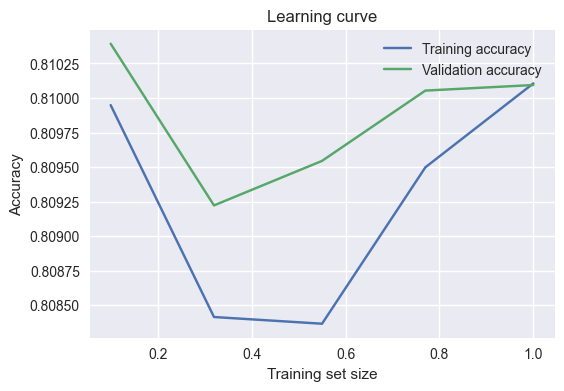

### Cross-validation score: 0.81


### Classification report:

,precision,recall,f1-score,support
0,0.882,0.721,0.793,58990.000
1,0.764,0.904,0.828,58990.000
accuracy,0.812,0.812,0.812,0.812
macro avg,0.823,0.812,0.811,117980.000
weighted avg,0.823,0.812,0.811,117980.000


### ROC AUC score = 0.836

### ROC AUC curve:

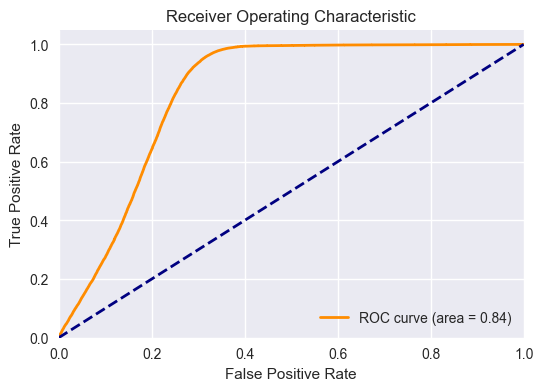

### Confusion matrix:

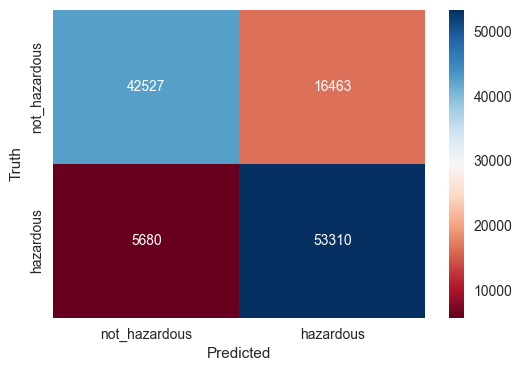

In [ ]:
model = LogisticRegression()

params = {'C': [0.1, 1, 10, 100],
          'penalty': ['l1', 'l2', 'elasticnet'],
          'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'],
          'max_iter': [200, 500, 1000]}

results[type(model).__name__] = (pipeline(model, params, data))

with open('models_roc_auc_results.json', 'w') as f:
    json.dump(results, f)

Метод K ближайших соседей --- подходит для данных, имеющий сложную структуру, однако склонен к переобучению.

### Best parameters: {'leaf_size': 50, 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}

### Learning curve:

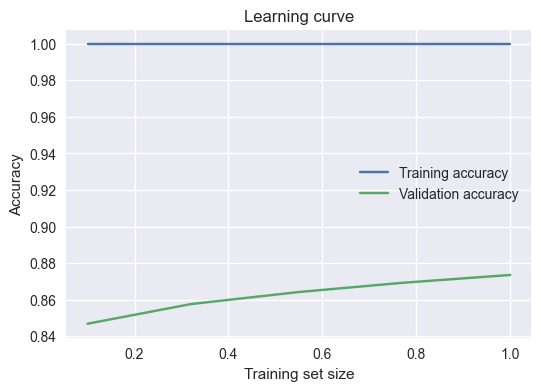

### Cross-validation score: 0.874


### Classification report:

,precision,recall,f1-score,support
0,0.943,0.808,0.870,58990.000
1,0.832,0.951,0.887,58990.000
accuracy,0.879,0.879,0.879,0.879
macro avg,0.887,0.879,0.879,117980.000
weighted avg,0.887,0.879,0.879,117980.000


### ROC AUC score = 0.943

### ROC AUC curve:

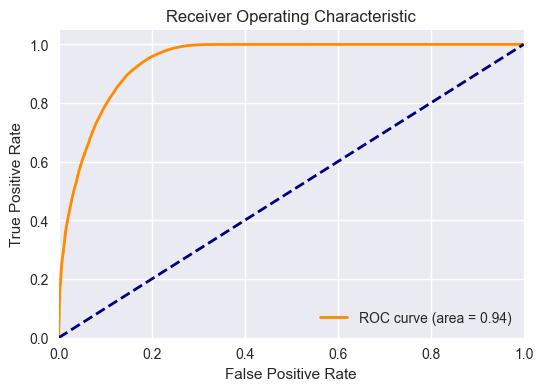

### Confusion matrix:

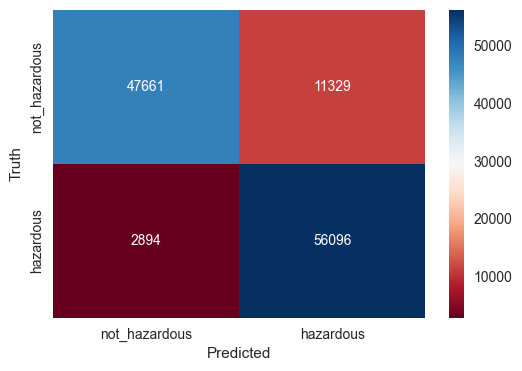

In [ ]:
model = KNeighborsClassifier()

params = {'n_neighbors': [5, 10, 20, 50],
          'weights': ['uniform', 'distance'],
          'leaf_size': [30, 40, 50],
          'p': [1, 2]}

results[type(model).__name__] = (pipeline(model, params, data))

with open('models_roc_auc_results.json', 'w') as f:
    json.dump(results, f)

Наивный байесовский классификатор основывается на применении теоремы Байеса и предполагает независимость признаков, на данных где признаки проявляют определенную зависимость (пускай и нелинейную) данный классификатор выступает заметно хуже остальных моделей.

### Best parameters: {'alpha': 0.5, 'norm': True}

### Learning curve:

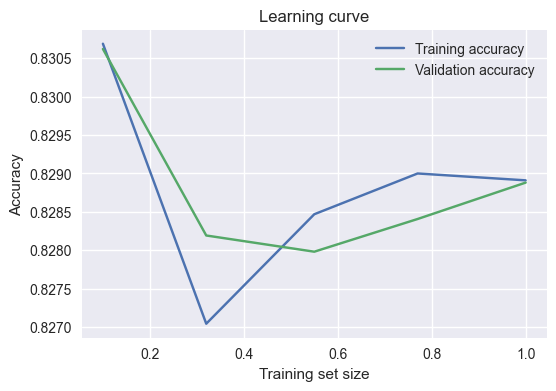

### Cross-validation score: 0.829


### Classification report:

,precision,recall,f1-score,support
0,0.876,0.937,0.905,58989.000
1,0.178,0.094,0.123,8633.000
accuracy,0.829,0.829,0.829,0.829
macro avg,0.527,0.515,0.514,67622.000
weighted avg,0.787,0.829,0.806,67622.000


### ROC AUC score = 0.546

### ROC AUC curve:

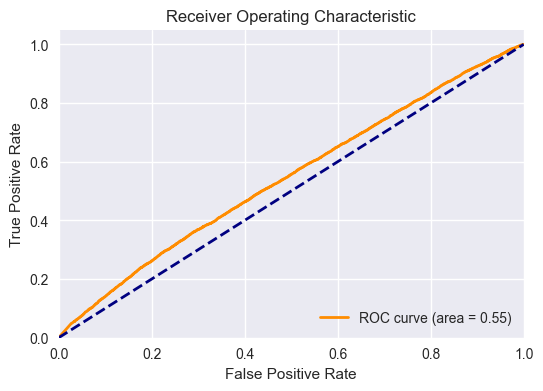

### Confusion matrix:

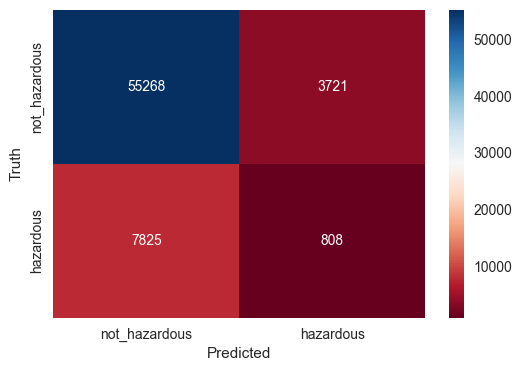

In [ ]:
model = ComplementNB()

# Для наивного байесовского классификатора не стандартизируются данные,
# так-как он не может работать с отрицательными значениями, которые возникли в результате стандартизации
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37, stratify=y)

orig_data = [X_train, X_test, y_train, y_test]

params = {'alpha': [0, 0.5, 1],
          'norm': [False, True]}

results[type(model).__name__] = (pipeline(model, params, orig_data))

with open('models_roc_auc_results.json', 'w') as f:
    json.dump(results, f)

Дерево решений --- основывается на разбиении данных на подмножества на основе значений прихнаков, отлично работает в случаях, когда определенный порог в признаках позволяет отделить подмножества положительных и отрицательных классов друг от друга.

### Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_split': 20, 'splitter': 'best'}

### Learning curve:

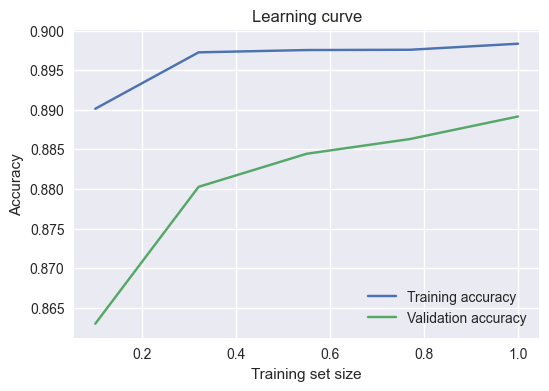

### Cross-validation score: 0.889


### Classification report:

,precision,recall,f1-score,support
0,0.936,0.835,0.882,58990.000
1,0.851,0.942,0.894,58990.000
accuracy,0.889,0.889,0.889,0.889
macro avg,0.893,0.889,0.888,117980.000
weighted avg,0.893,0.889,0.888,117980.000


### ROC AUC score = 0.956

### ROC AUC curve:

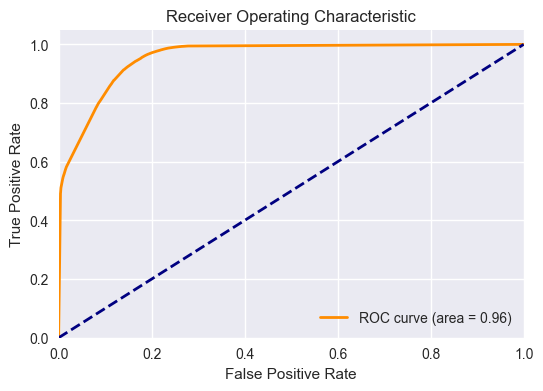

### Confusion matrix:

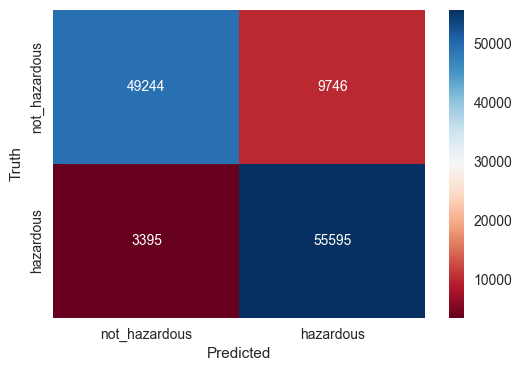

In [ ]:
model = DecisionTreeClassifier()

params = {'criterion': ['gini', 'entropy', 'log_loss'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 10, 20, 30, 40],
          'min_samples_split': [2, 5, 10, 20],
          'max_features': [None, 'sqrt', 'log2']}

results[type(model).__name__] = (pipeline(model, params, data))

with open('models_roc_auc_results.json', 'w') as f:
    json.dump(results, f)

Метод случайного леса представляет собой ансамбль множества деревьев решений, объединяя их результаты для улучшения точности и устойчивости.

### Best parameters: {'criterion': 'log_loss', 'max_depth': 40, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 40}

### Learning curve:

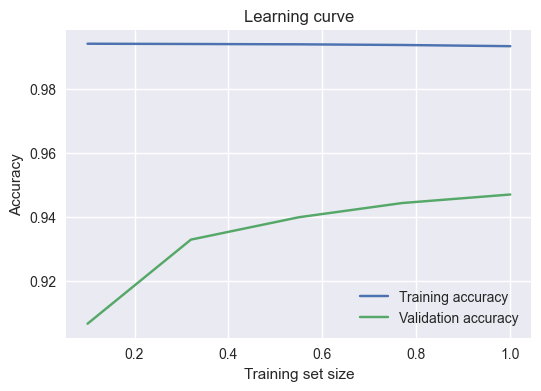

### Cross-validation score: 0.947


### Classification report:

,precision,recall,f1-score,support
0,0.946,0.954,0.950,58990.000
1,0.953,0.945,0.949,58990.000
accuracy,0.949,0.949,0.949,0.949
macro avg,0.949,0.949,0.949,117980.000
weighted avg,0.949,0.949,0.949,117980.000


### ROC AUC score = 0.991

### ROC AUC curve:

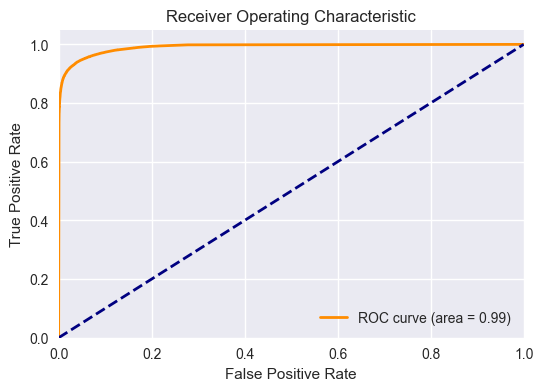

### Confusion matrix:

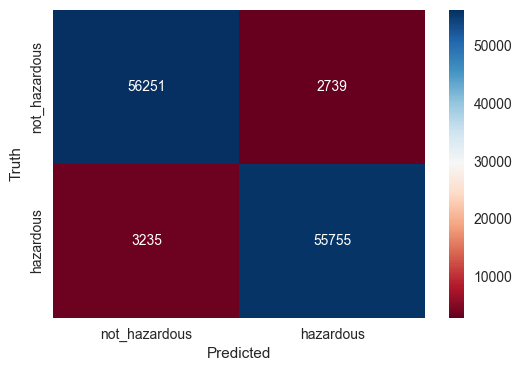

In [ ]:
model = RandomForestClassifier()

params = {'n_estimators': [10, 20, 30, 40],
          'criterion': ['gini', 'entropy', 'log_loss'],
          'max_depth': [None, 10, 20, 30, 40],
          'min_samples_split': [2, 5, 10, 20],
          'max_features': [None, 'sqrt', 'log2']}

results[type(model).__name__] = (pipeline(model, params, data))

with open('models_roc_auc_results.json', 'w') as f:
    json.dump(results, f)

Метод градиентного бустинга последовательно строит деревья решений, начиная со слабых деревьев и, корректируя их ошибки, строит более сильные деревья.

### Best parameters: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5}

### Learning curve:

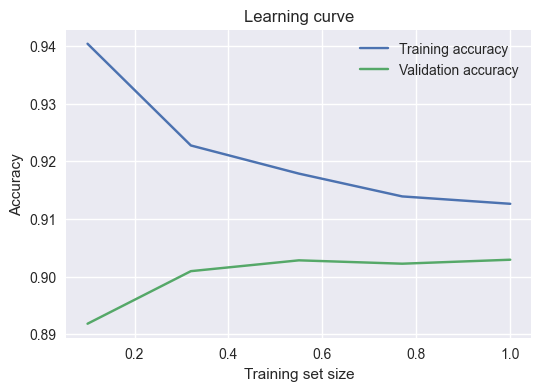

### Cross-validation score: 0.905


### Classification report:

,precision,recall,f1-score,support
0,0.969,0.838,0.899,58990.000
1,0.857,0.973,0.912,58990.000
accuracy,0.906,0.906,0.906,0.906
macro avg,0.913,0.906,0.905,117980.000
weighted avg,0.913,0.906,0.905,117980.000


### ROC AUC score = 0.983

### ROC AUC curve:

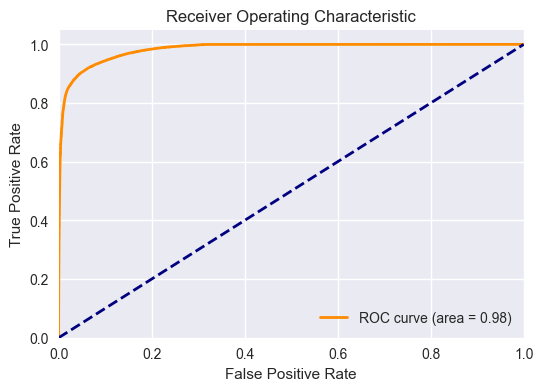

### Confusion matrix:

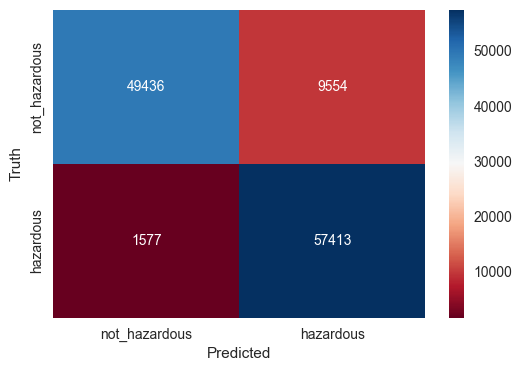

In [ ]:
model = GradientBoostingClassifier()

params = {'loss': ['log_loss', 'exponential'],
          'learning_rate': [0.1, 0.01, 0.001],
          'max_depth': [10],
          'min_samples_split': [5],
          'max_features': ['log2']}

results[type(model).__name__] = (pipeline(model, params, data))

with open('models_roc_auc_results.json', 'w') as f:
    json.dump(results, f)

Адаптивный бустинг также строит последовательность деревьев решений, улучшая новые из них благодаря увеличению веса приверов, которые были неверно классифицированы.

### Best parameters: {'learning_rate': 1, 'n_estimators': 100}

c:\Users\Никита\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Никита\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Никита\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Никита\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default)

### Learning curve:

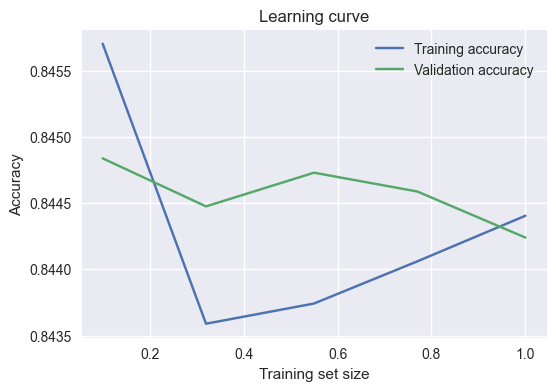

c:\Users\Никита\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Никита\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Никита\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Никита\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default)

### Cross-validation score: 0.844


### Classification report:

,precision,recall,f1-score,support
0,0.981,0.704,0.820,58990.000
1,0.769,0.986,0.864,58990.000
accuracy,0.845,0.845,0.845,0.845
macro avg,0.875,0.845,0.842,117980.000
weighted avg,0.875,0.845,0.842,117980.000


### ROC AUC score = 0.919

### ROC AUC curve:

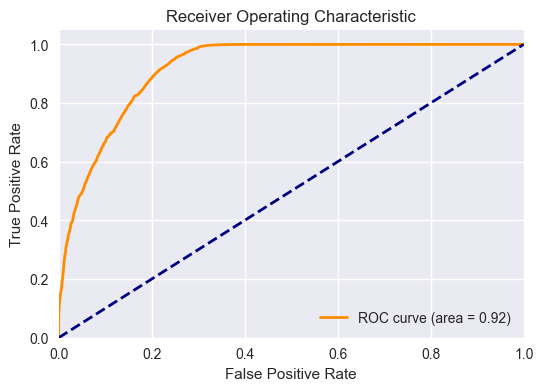

### Confusion matrix:

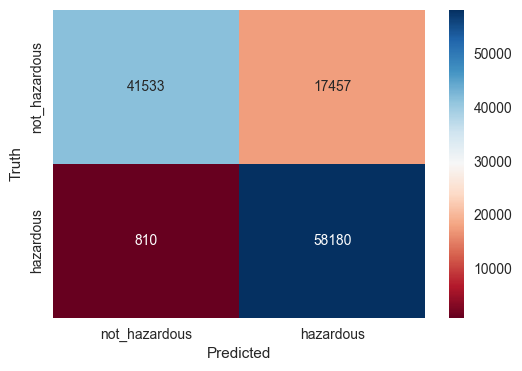

In [ ]:
model = AdaBoostClassifier()

params = {'n_estimators': [50, 75, 100],
          'learning_rate': [0.01, 0.1, 1, 2]}

results[type(model).__name__] = (pipeline(model, params, data))

with open('models_roc_auc_results.json', 'w') as f:
    json.dump(results, f)

### Глубокое обучение

In [ ]:
# Использование GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Создаем конвейер для обучения и валидации глубоких моделей
def nn_pipeline(model, params, data, criterion, optimizer):
    kf = KFold(n_splits=params['k_folds'], shuffle=True)

    X_train, X_test, y_train, y_test = data

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train.array, dtype=torch.float32).view(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test.array, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=params['batch_size'],
    )

    train_loss_folds = []
    val_loss_folds = []
    test_loss_folds = []
    accuracies_folds = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):

        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=params['batch_size'],
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )

        val_loader = DataLoader(
            dataset=train_dataset,
            batch_size=params['batch_size'],
            sampler=torch.utils.data.SubsetRandomSampler(val_idx),
        )

        train_loss_epochs = []
        val_loss_epochs = []

        for epoch in range(params['num_epochs']):
            train_loss_batches = []
            model.train()
            for batch_idx, (input, target) in enumerate(train_loader):
                input, target = input.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(input)

                loss = criterion(output, target)
                train_loss_batches.append(loss)
                loss.backward()

                optimizer.step()

            train_loss_epochs.append(np.array([loss.cpu().detach().numpy() for loss in train_loss_batches]).mean())

            val_loss_batches = []
            model.eval()
            with torch.no_grad():
                for batch_idx, (input, target) in enumerate(val_loader):
                    input, target = input.to(device), target.to(device)
                    output = model(input)

                    loss = criterion(output, target)
                    val_loss_batches.append(loss)

                val_loss_epochs.append(np.array([loss.cpu().detach().numpy() for loss in val_loss_batches]).mean())

        train_loss_folds.append(train_loss_epochs)
        val_loss_folds.append(val_loss_epochs)

        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).cpu().detach().numpy()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = correct / len(test_loader.dataset)

        test_loss_folds.append(test_loss)
        accuracies_folds.append(accuracy)

        print(f"Fold {fold + 1}| Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.3f})\n")

    train_loss_folds_means = np.array(train_loss_folds).T.mean(axis=1)
    val_loss_folds_means = np.array(val_loss_folds).T.mean(axis=1)

    display(Markdown(f'### Learning curve:'))
    plt.figure(figsize=(6, 4))
    plt.style.use('seaborn-v0_8')
    sns.lineplot(x=[i+1 for i in range(params['num_epochs'])], y=train_loss_folds_means, label='Training loss')
    sns.lineplot(x=[i+1 for i in range(params['num_epochs'])], y=val_loss_folds_means, label='Validation loss')
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.title('Learning curve')
    plt.legend()
    plt.show()

    display(Markdown(f'###Cross-validation score: {np.mean(accuracies_folds):.3f}'))

    model.eval()
    with torch.no_grad():
        y_pred_logits = model(X_test.to(device)).cpu().detach().numpy()

        y_pred_proba = torch.sigmoid(torch.tensor(y_pred_logits, dtype=torch.float32)).numpy()

        y_pred = (y_pred_proba >= 0.5).astype(int)

    report = classification_report(y_test, y_pred.round(), output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(3)
    display(Markdown(f'###Classification report:'))
    display(report_df)

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    display(Markdown(f'###ROC AUC score: {roc_auc:.3f}'))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    conf_mat = confusion_matrix(y_test, y_pred.round())
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='RdBu', xticklabels=['not_hazardous', 'hazardous'], yticklabels=['not_hazardous', 'hazardous'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

    model_filename = os.path.join('models', f'{type(model).__name__}.pth')
    torch.save(model.state_dict(), model_filename)

    return list(fpr), list(tpr), roc_auc

In [ ]:
# Создаем простейшую нейросеть на основе полносвязных слоев
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(5, 12)
        self.fc2 = nn.Linear(12, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Fold 1| Test set: Average loss: 0.0092, Accuracy: 58990/117980 (0.500)

Fold 2| Test set: Average loss: 0.0087, Accuracy: 58990/117980 (0.500)

Fold 3| Test set: Average loss: 0.0087, Accuracy: 58990/117980 (0.500)

Fold 4| Test set: Average loss: 0.0085, Accuracy: 58990/117980 (0.500)

Fold 5| Test set: Average loss: 0.0085, Accuracy: 58990/117980 (0.500)



### Learning curve:

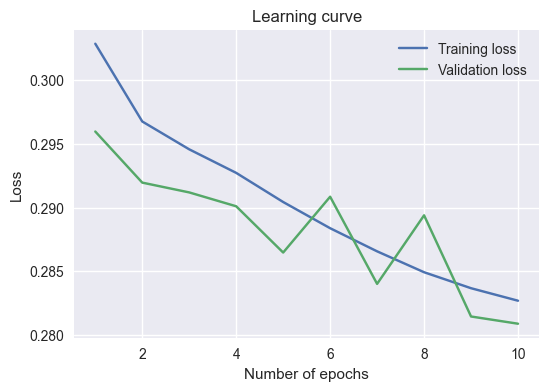

###Cross-validation score: 0.500

###Classification report:

,precision,recall,f1-score,support
0.0,0.917,0.791,0.849,58990.00
1.0,0.816,0.929,0.869,58990.00
accuracy,0.860,0.860,0.860,0.86
macro avg,0.867,0.860,0.859,117980.00
weighted avg,0.867,0.860,0.859,117980.00


###ROC AUC score: 0.950

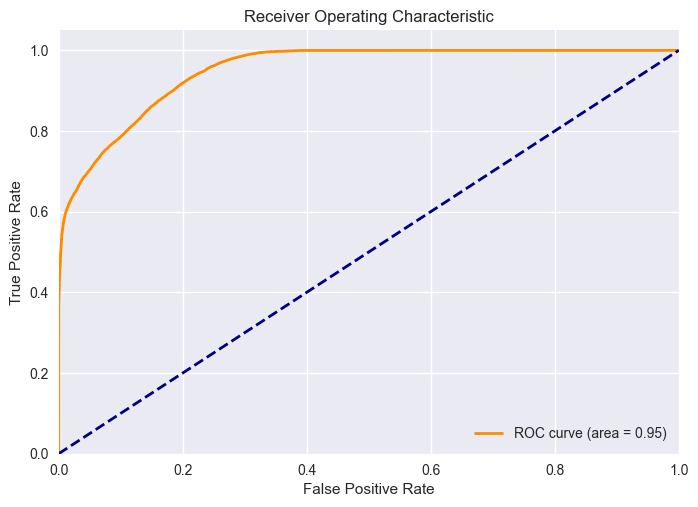

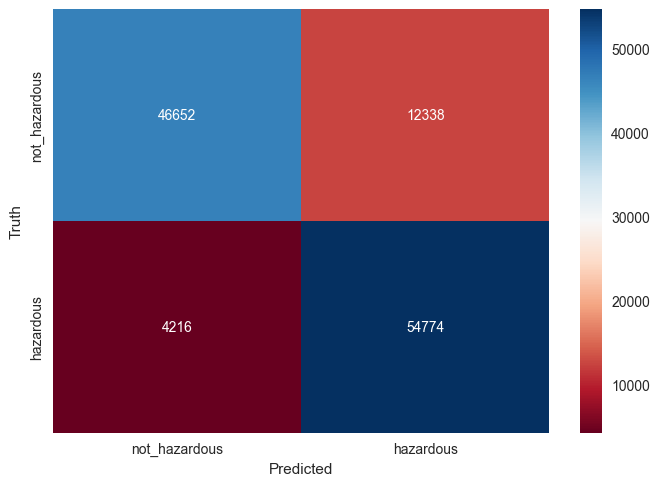

In [ ]:
# Нейронная сеть №1
model = SimpleNet().to(device)

params = {'batch_size': 32,
          'k_folds': 5,
          'num_epochs': 10,
          'lr': 0.01,
          'momentum': 0.5}

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])

results[type(model).__name__] = (nn_pipeline(model, params, data, criterion, optimizer))

with open('models_roc_auc_results.json', 'w') as f:
    json.dump(results, f)

In [ ]:
# Создаем более сложную нейросеть на основе полносвязных слоев
class UpgradedNet(nn.Module):
    def __init__(self):
        super(UpgradedNet, self).__init__()
        self.fc1 = nn.Linear(5, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)

        return x

Fold 1| Test set: Average loss: 0.0057, Accuracy: 58990/117980 (0.500)

Fold 2| Test set: Average loss: 0.0057, Accuracy: 58990/117980 (0.500)

Fold 3| Test set: Average loss: 0.0057, Accuracy: 58990/117980 (0.500)

Fold 4| Test set: Average loss: 0.0055, Accuracy: 58990/117980 (0.500)

Fold 5| Test set: Average loss: 0.0057, Accuracy: 58990/117980 (0.500)



### Learning curve:

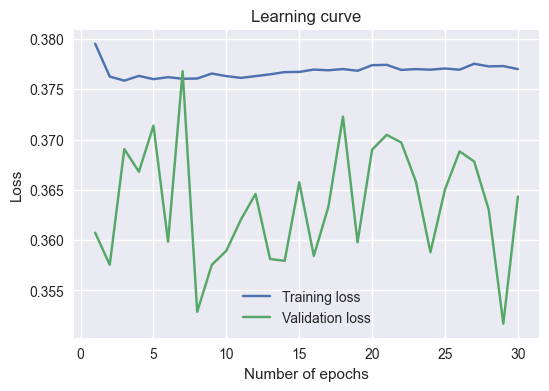

###Cross-validation score: 0.500

###Classification report:

,precision,recall,f1-score,support
0.0,0.995,0.668,0.799,58990.000
1.0,0.750,0.997,0.856,58990.000
accuracy,0.832,0.832,0.832,0.832
macro avg,0.873,0.832,0.828,117980.000
weighted avg,0.873,0.832,0.828,117980.000


###ROC AUC score: 0.909

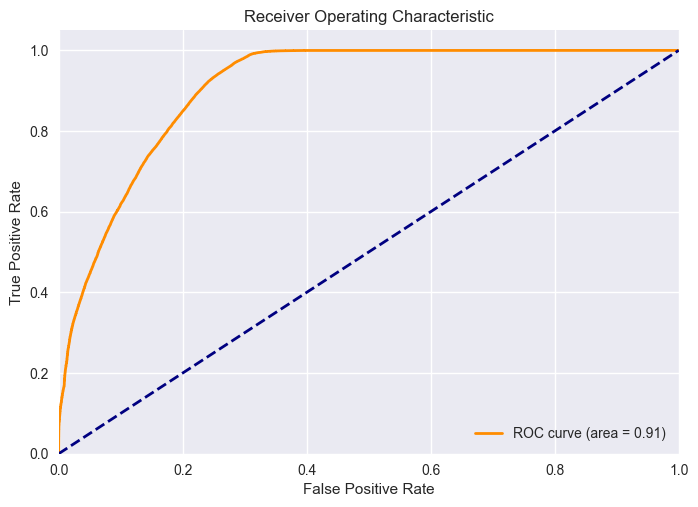

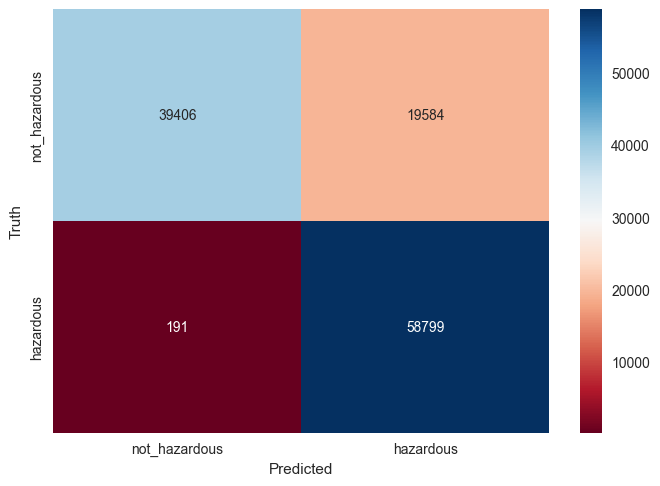

In [ ]:
# Нейронная сеть №2
model = UpgradedNet().to(device)

params = {'batch_size': 64,
          'k_folds': 5,
          'num_epochs': 30,
          'lr': 0.01,
          'weight_decay': 0.01}

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

results[type(model).__name__] = (nn_pipeline(model, params, data, criterion, optimizer))

with open('models_roc_auc_results.json', 'w') as f:
    json.dump(results, f)

### Сравнение моделей

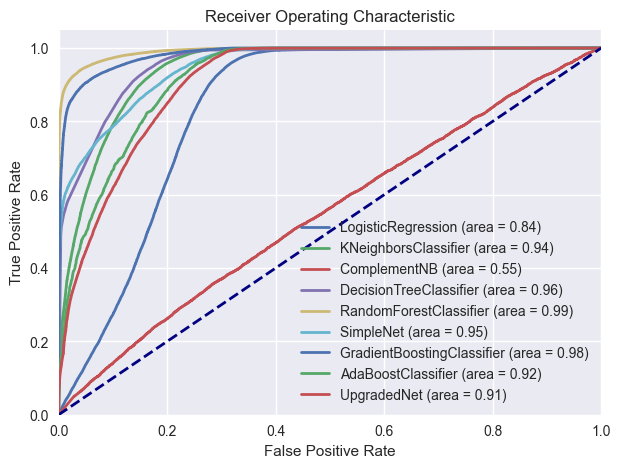

In [ ]:
# Отображение кривых ROC AUC для каждой из моделей
plt.figure(figsize=(7, 5))

for model, (fpr, tpr, roc_auc) in results.items():
    plt.plot(fpr, tpr, lw=2, label='%s (area = %0.2f)' % (model, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right", fontsize="10")
plt.show()

В данном ноутбуке представлены результаты моделей на датасете, дополненном синтетическими данными, благодаря SMOTE.

Параллельно, исследовались те же модели для других форматов датасета, а именно:
* Basic --- Изначальный датасет, только предварительная очистка данных
* SMOTE --- Изначальный датасет, дополненный синтетическими данными
* Stripped --- Уменьшенный датасет, из которого удалены все астероиды слишком малого размера
* Stripped SMOTE --- Уменьшенный датасет, дополненный синтетическими данными

Для каждого из наборов датасетов были проведены аналогичные исследования и выбраны лучшие модели по метрики ROC AUC + Recall.

<style>
.grid-container {
    display: grid;
    grid-template-columns: auto auto;
}
</style>

<div class="grid-container">
<div>
<img src="https://github.com/EkaterinaRyu/NEO_classifier/blob/master/NEO_classifier_streamlit/colab_analysis/basic.png?raw=true" width="500px" title="basic"/>
</div>
<div>
<img src="https://github.com/EkaterinaRyu/NEO_classifier/blob/master/NEO_classifier_streamlit/colab_analysis/smote.png?raw=true" width="500px" title="smote"/>
</div>
<div>
<img src="https://github.com/EkaterinaRyu/NEO_classifier/blob/master/NEO_classifier_streamlit/colab_analysis/stripped.png?raw=true" width="500px" title="stripped"/>
</div>
<div>
<img src="https://github.com/EkaterinaRyu/NEO_classifier/blob/master/NEO_classifier_streamlit/colab_analysis/stripped smote.png?raw=true" width="500px" title="stripped smote"/>
</div>
</div>

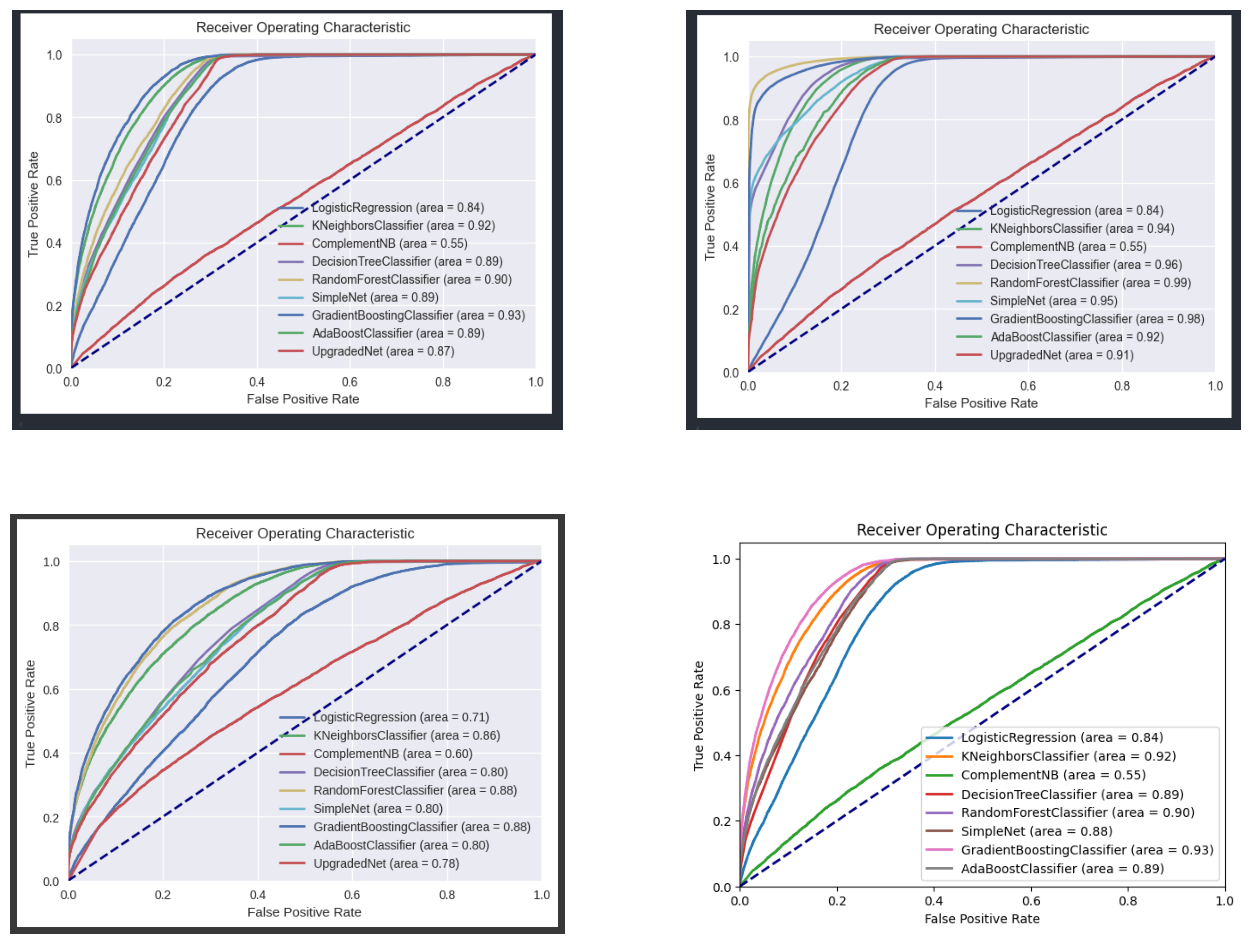

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from urllib import request
from PIL import Image
import numpy as np

# Load the images
img1 = Image.open(request.urlopen("https://github.com/EkaterinaRyu/NEO_classifier/blob/master/NEO_classifier_streamlit/colab_analysis/basic.png?raw=true"))
img2 = Image.open(request.urlopen("https://github.com/EkaterinaRyu/NEO_classifier/blob/master/NEO_classifier_streamlit/colab_analysis/smote.png?raw=true"))
img3 = Image.open(request.urlopen("https://github.com/EkaterinaRyu/NEO_classifier/blob/master/NEO_classifier_streamlit/colab_analysis/stripped.png?raw=true"))
img4 = Image.open(request.urlopen("https://github.com/EkaterinaRyu/NEO_classifier/blob/master/NEO_classifier_streamlit/colab_analysis/stripped_smote.png?raw=true"))

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Display the images
axs[0, 0].imshow(img1)
axs[0, 1].imshow(img2)
axs[1, 0].imshow(img3)
axs[1, 1].imshow(img4)

# Remove the axis labels
for ax in axs.flat:
    ax.axis('off')

# Show the plot
plt.show()


Исследование показало, что на текущем наборе данных наилучшим образом справляются дерево решений, а также ансамблевые методы на их основе такие как метод случайного леса и градиентный бустинг (данныя тенденция сохранилась и на других наборах данных).

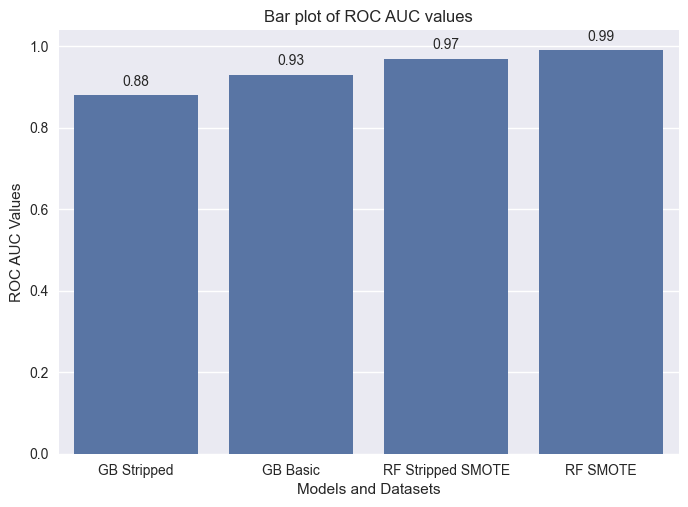

In [ ]:
roc_auc_values = [0.88, 0.93, 0.97, 0.99]
labels = ['GB Stripped', 'GB Basic', 'RF Stripped SMOTE', 'RF SMOTE']

roc_auc_df = pd.DataFrame({'Labels': labels, 'Values': roc_auc_values})

roc_auc_df = roc_auc_df.sort_values(by='Values')

ax = sns.barplot(x='Labels', y='Values', data=roc_auc_df)

plt.xlabel('Models and Datasets')
plt.ylabel('ROC AUC Values')
plt.title('Bar plot of ROC AUC values')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

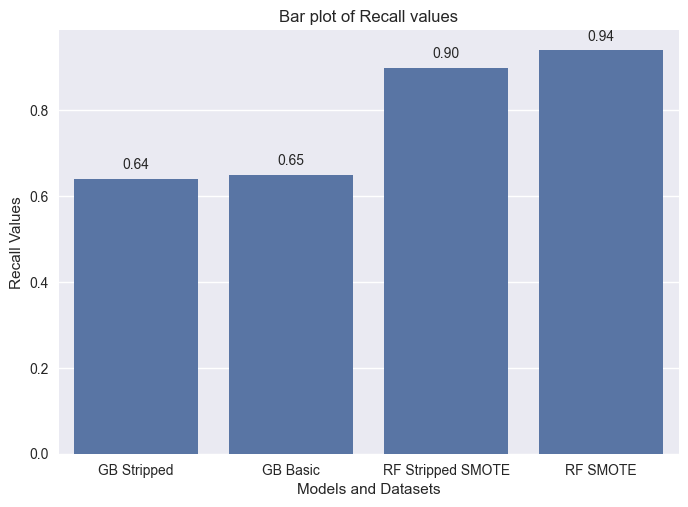

In [ ]:
recall_values = [0.64, 0.65, 0.90, 0.94]
labels = ['GB Stripped', 'GB Basic', 'RF Stripped SMOTE', 'RF SMOTE']

recall_df = pd.DataFrame({'Labels': labels, 'Values': recall_values})

recall_df = recall_df.sort_values(by='Values')

ax = sns.barplot(x='Labels', y='Values', data=recall_df)

plt.xlabel('Models and Datasets')
plt.ylabel('Recall Values')
plt.title('Bar plot of Recall values')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Наилучший результат показал метод случайного леса, обученный на изначальной датасете, дополненным синтетическими данными.

### Classification report:

,precision,recall,f1-score,support
0,0.980,0.984,0.982,58989.000
1,0.887,0.863,0.875,8633.000
accuracy,0.968,0.968,0.968,0.968
macro avg,0.933,0.923,0.928,67622.000
weighted avg,0.968,0.968,0.968,67622.000


### ROC AUC score = 0.987

### Confusion matrix:

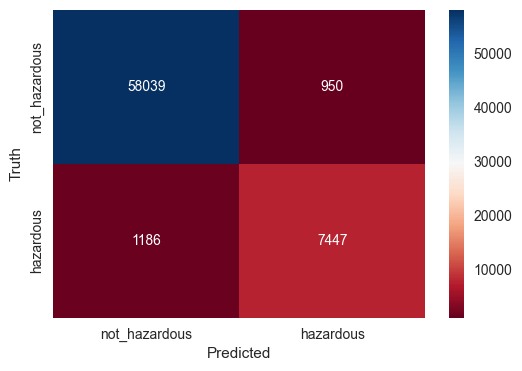

In [ ]:
# Проверим лучшую модель на изначальном датасете (без использования синтетических данных)
best_model = load('models/RandomForestClassifier.joblib')

y = dataset_clean['is_hazardous']
X = dataset_clean.drop('is_hazardous', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37, stratify=y, shuffle=True)

X_test_scaled = scaler.transform(X_test)

y_pred = best_model.predict(X_test_scaled)

y_pred = best_model.predict(X_test_scaled)

report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).transpose().round(3)

display(Markdown(f'### Classification report:'))
display(report_df)

y_pred_proba = best_model.predict_proba(X_test_scaled)[:,1]
display(Markdown(f'### ROC AUC score = {round(roc_auc_score(y_test, y_pred_proba), 3)}'))

display(Markdown(f'### Confusion matrix:'))
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
labels = ['not_hazardous', 'hazardous']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='RdBu', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Выводы: Модель, обученная на синтетических данных сохраняет крайне высокие результаты и на изначальном датасете, отражающем реальную природу данных.